# Introduction

Quality assessment is an essential step in the wine making process as it helps ensure consistency and consumer satisfaction. The quality of wine has historically been evaluated by wine makers and sommeliers, who leverage their training and expertise to determine if a product meets acceptable standards (1). While there have been advancements in the detection of the physicochemical properties of wine and how they relate to flavour (2), quality assessment remains a subjective metric. 

Here we ask if wine quality can be predicted using machine learning. Our focus is to create an interpretable linear regression model trained on physicochemical wine data to perform this task. The utility of such a model is two-fold as it can be used as a tool to help less experienced wine makers and sommeliers get a sense of the quality of a given wine. Furthermore, the model would help to provide a more objective framework for wine assessment through interpretation of its coefficients. To achieve this, we will train our model on data related to vinho verde white wines from the Minho region of Portugal which contains the physicochemical and sensory data of 4898 wines (3).

In [4]:
import pandas as pd
import altair_ally as aly
import altair as alt
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
import pointblank as pb
from deepchecks.tabular import Dataset
from deepchecks.tabular.checks import FeatureLabelCorrelation

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.metrics import root_mean_squared_error, r2_score

import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

/Users/samlokanc/Library/miniforge3/envs/dsci522project/lib/python3.10/site-packages/deepchecks/core/serialization/dataframe/html.py:16: UserWarning:

pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.



In [2]:
aly.alt.data_transformers.enable('vegafusion')

DataTransformerRegistry.enable('vegafusion')

In [3]:
origin_df = pd.read_csv('../data/winequality-white.csv', sep=';', encoding='utf-8')

In [4]:
# looking at head and tail of data
origin_df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
...,...,...,...,...,...,...,...,...,...,...,...,...
4893,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6
4894,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5
4895,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6
4896,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7


In [5]:
expected_cols = ['fixed acidity', 
                 'volatile acidity', 
                 'citric acid',
                 'residual sugar',
                 'chlorides',
                 'free sulfur dioxide',
                 'total sulfur dioxide',
                 'density',
                 'pH',
                 'sulphates',
                 'alcohol',
                 'quality']

schema = pb.Schema(columns = [('fixed acidity', 'float64'), 
                 ('volatile acidity', 'float64'), 
                 ('citric acid', 'float64'),
                 ('residual sugar', 'float64'),
                 ('chlorides', 'float64'),
                 ('free sulfur dioxide', 'float64'),
                 ('total sulfur dioxide', 'float64'),
                 ('density', 'float64'),
                 ('pH', 'float64'),
                 ('sulphates', 'float64'),
                 ('alcohol', 'float64'),
                 ('quality', 'int64')])

validation = (
    pb.Validate(origin_df)
    .col_exists(columns=expected_cols)
    .col_vals_not_null(columns=expected_cols, thresholds=0.0)
    .col_schema_match(schema=schema)
    .rows_distinct()
    .interrogate()
)
validation

Validate(data=      fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0               7.0              0.27         0.36            20.7      0.045   
1               6.3              0.30         0.34             1.6      0.049   
2               8.1              0.28         0.40             6.9      0.050   
3               7.2              0.23         0.32             8.5      0.058   
4               7.2              0.23         0.32             8.5      0.058   
...             ...               ...          ...             ...        ...   
4893            6.2              0.21         0.29             1.6      0.039   
4894            6.6              0.32         0.36             8.0      0.047   
4895            6.5              0.24         0.19             1.2      0.041   
4896            5.5              0.29         0.30             1.1      0.022   
4897            6.0              0.21         0.38             0.8      0.020   

      free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                    45.0                 170.0  1.00100  3.00       0.45   
1                    14.0                 132.0  0.99400  3.30       0.49   
2                    30.0                  97.0  0.99510  3.26       0.44   
3                    47.0                 186.0  0.99560  3.19       0.40   
4                    47.0                 186.0  0.99560  3.19       0.40   
...                   ...                   ...      ...   ...        ...   
4893                 24.0                  92.0  0.99114  3.27       0.50   
4894                 57.0                 168.0  0.99490  3.15       0.46   
4895                 30.0                 111.0  0.99254  2.99       0.46   
4896                 20.0                 110.0  0.98869  3.34       0.38   
4897                 22.0                  98.0  0.98941  3.26       0.32   

      alcohol  quality  
0         8.8        6  
1         9.5        6  
2        10.1        6  
3         9.9        6  
4         9.9        6  
...       ...      ...  
4893     11.2        6  
4894      9.6        5  
4895      9.4        6  
4896     12.8        7  
4897     11.8        6  

[4898 rows x 12 columns], tbl_name=None, label=None, thresholds=Thresholds(warning=None, error=None, critical=None), actions=None, final_actions=None, brief=None, lang='en', locale='en')

In [6]:
# No anomalous correlations between target/response variable and features/explanatory variables
# No anomalous correlations between features/explanatory variables

wine_quality_ds = Dataset(origin_df, label="quality", cat_features=[])

check_feat_lab_corr = FeatureLabelCorrelation().add_condition_feature_pps_less_than(0.9)
check_feat_lab_corr_result = check_feat_lab_corr.run(dataset=wine_quality_ds)

if not check_feat_lab_corr_result.passed_conditions():
    raise ValueError("Feature-Label correlation exceeds the maximum acceptable threshold.")

In [7]:
# No outlier or anomalous values

pb.Validate(origin_df).col_vals_between(columns="quality", left=0, right=10).interrogate()

Validate(data=      fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0               7.0              0.27         0.36            20.7      0.045   
1               6.3              0.30         0.34             1.6      0.049   
2               8.1              0.28         0.40             6.9      0.050   
3               7.2              0.23         0.32             8.5      0.058   
4               7.2              0.23         0.32             8.5      0.058   
...             ...               ...          ...             ...        ...   
4893            6.2              0.21         0.29             1.6      0.039   
4894            6.6              0.32         0.36             8.0      0.047   
4895            6.5              0.24         0.19             1.2      0.041   
4896            5.5              0.29         0.30             1.1      0.022   
4897            6.0              0.21         0.38             0.8      0.020   

      free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                    45.0                 170.0  1.00100  3.00       0.45   
1                    14.0                 132.0  0.99400  3.30       0.49   
2                    30.0                  97.0  0.99510  3.26       0.44   
3                    47.0                 186.0  0.99560  3.19       0.40   
4                    47.0                 186.0  0.99560  3.19       0.40   
...                   ...                   ...      ...   ...        ...   
4893                 24.0                  92.0  0.99114  3.27       0.50   
4894                 57.0                 168.0  0.99490  3.15       0.46   
4895                 30.0                 111.0  0.99254  2.99       0.46   
4896                 20.0                 110.0  0.98869  3.34       0.38   
4897                 22.0                  98.0  0.98941  3.26       0.32   

      alcohol  quality  
0         8.8        6  
1         9.5        6  
2        10.1        6  
3         9.9        6  
4         9.9        6  
...       ...      ...  
4893     11.2        6  
4894      9.6        5  
4895      9.4        6  
4896     12.8        7  
4897     11.8        6  

[4898 rows x 12 columns], tbl_name=None, label=None, thresholds=Thresholds(warning=None, error=None, critical=None), actions=None, final_actions=None, brief=None, lang='en', locale='en')

In [8]:
# split the dataset into train and test sets
train_df, test_df = train_test_split(
    origin_df,
    test_size=0.25,
    random_state=42,
    stratify=origin_df["quality"]
)

# separate the features and target
X_train = train_df.drop(columns="quality")
y_train = train_df["quality"]
X_test = test_df.drop(columns="quality")
y_test = test_df["quality"]

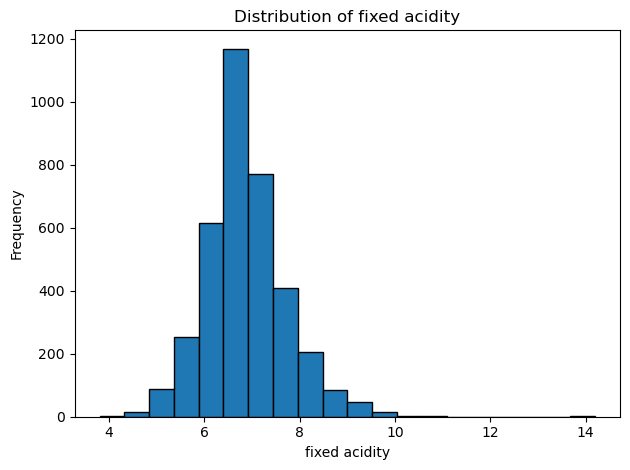

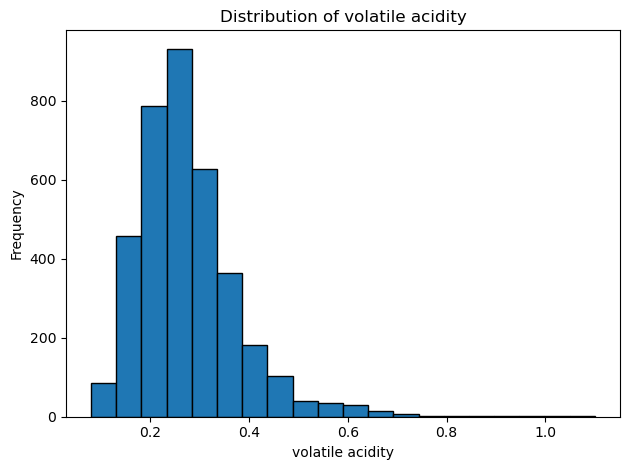

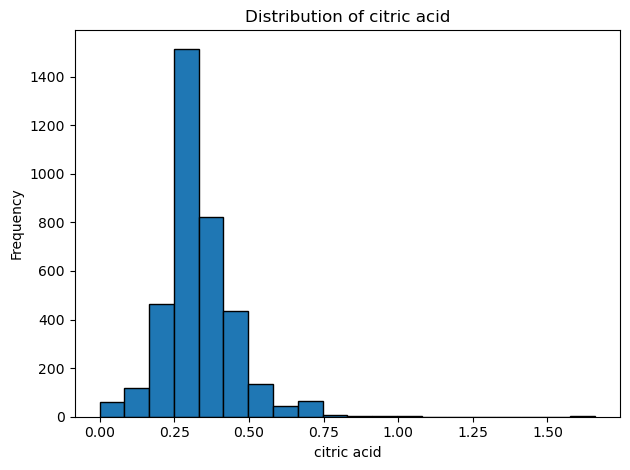

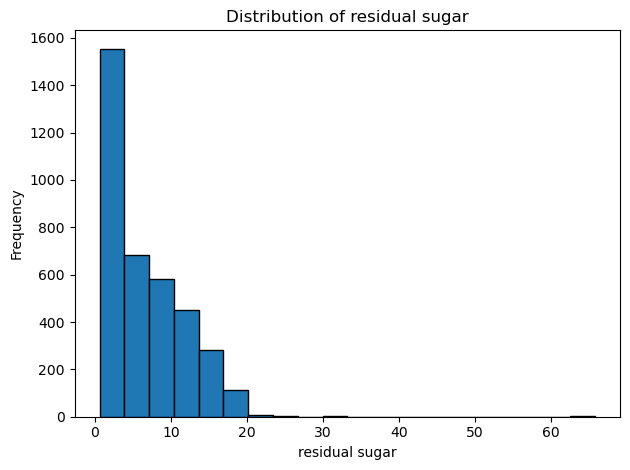

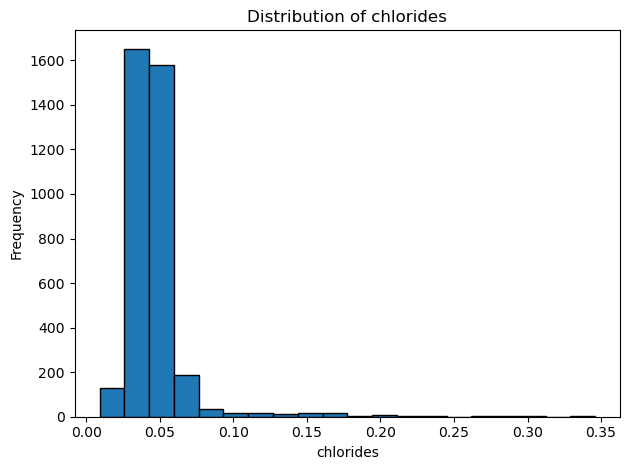

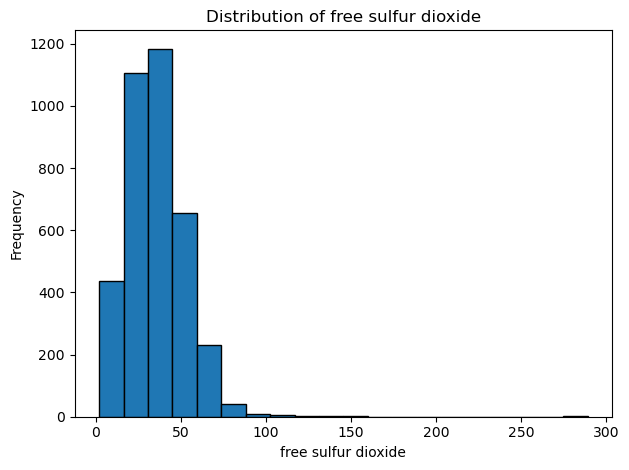

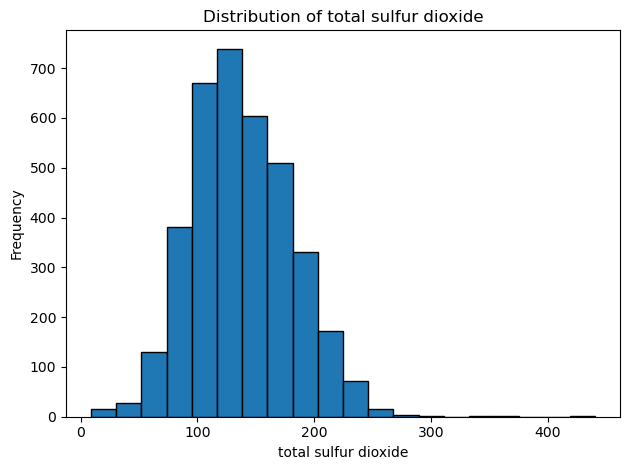

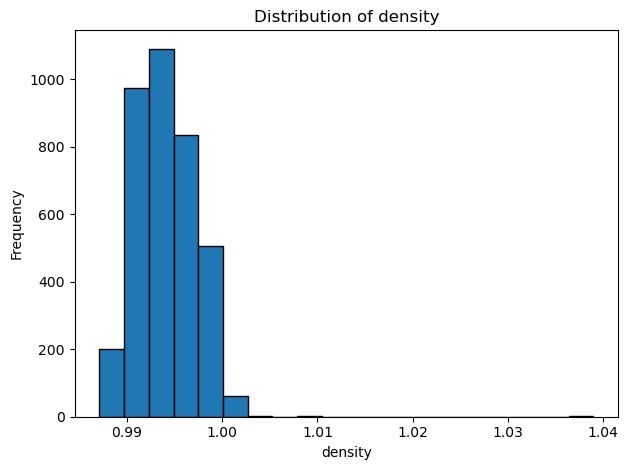

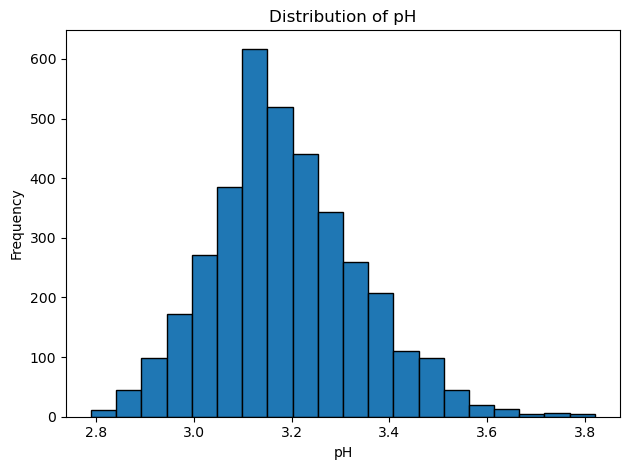

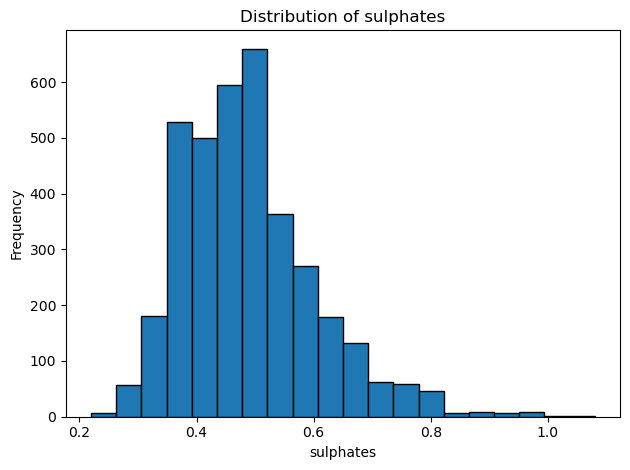

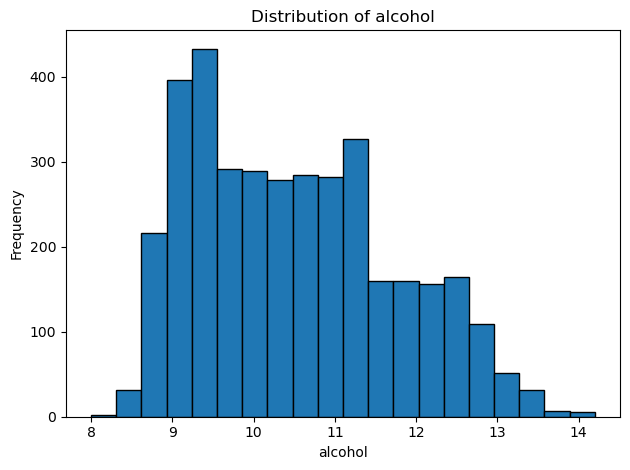

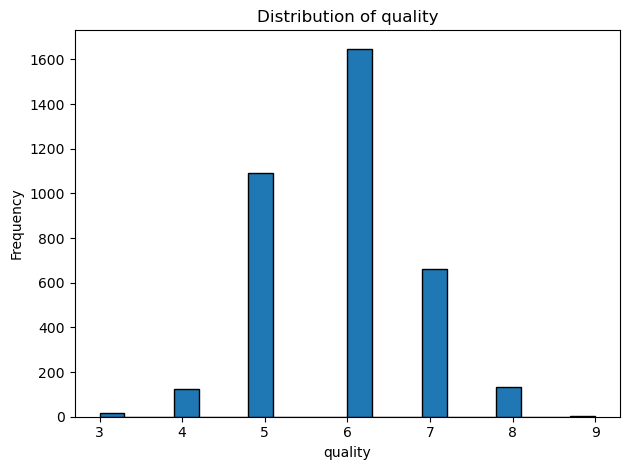

In [9]:
# plotting a bar graph for each variable
for feat in train_df.columns.tolist():
    plt.hist(train_df[feat], bins = 20, edgecolor='black')
    plt.xlabel(feat)
    plt.ylabel('Frequency')
    plt.title(f'Distribution of {feat}')
    plt.tight_layout()
    plt.show()

By taking a look at the individual distributions of the variables, we can see that the majority of them are approximately normal with some degree of right-skew. This tells us that most of the values tend to cluster around the average, possibly an industry standard, with the more extreme values tending to fall above the average rather than below it. The distributions of residual sugar and alcohol content break this pattern as the residual sugar plot follows a more exponential pattern, and the distribution of alcohol content is still approximately normal but also shows a tendency towards uniformity.

In [10]:
aly.corr(train_df)

alt.ConcatChart(...)

By taking a look at the Pearson and Spearman correlations, we can get a sense of what variables will be more informative about the predicted quality and which variables may be collinear. Based on the plot, a higher alcohol level is associated with a higher quality rating, while a higher density and chloride value is associated with a lower quality rating. Also, the plot suggests a strong linear correlation between multiple variables such as density and residual sugar and density and alcohol.

For exploratory purposes, we first create an ordinary least squares linear regression model including all predictors:

In [11]:
model = smf.ols("y_train ~ X_train", data=train_df)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                y_train   R-squared:                       0.291
Model:                            OLS   Adj. R-squared:                  0.289
Method:                 Least Squares   F-statistic:                     136.7
Date:                Thu, 04 Dec 2025   Prob (F-statistic):          8.26e-264
Time:                        09:30:27   Log-Likelihood:                -4133.8
No. Observations:                3673   AIC:                             8292.
Df Residuals:                    3661   BIC:                             8366.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept     143.6839     20.476      7.017      

This model has an R-squared value of 0.291, meaning that the model explains roughly 29% of variability in the data. The R-squared value is close to that of the adjusted R-squared, suggesting most predictors contribute explanatory power to the model.  
The p-value of the F-statistics is small, indicating that at least one predictor has a statistically significant assocation with the response.  
The output reveals that the condition number of the model is large, possibly indicating strong multicollinearity. Thus, we will opt for a ridge regression to induce an L2 penalty on correlated variables.

In [12]:
numeric_features = X_train.columns
numeric_transformer = StandardScaler()

In [13]:
# create preprocessing pipeline
model = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
        ("regressor", RidgeCV())
    ]
)

In [14]:
# fit the model on the training data
model.fit(X_train, y_train)

,steps,"[('scaler', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,alphas,"(0.1, ...)"
,fit_intercept,True
,scoring,None
,cv,None


In [15]:
# use the model to predict on the testing data
y_pred = model.predict(X_test)

# evaluate RMSE and R-squared values
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.3f}")
print(f"R^2: {r2:.3f}")

RMSE: 0.766
R^2: 0.252


In [16]:
linreg = model.named_steps["regressor"]
coef_df = pd.DataFrame(
    {"feature": X_train.columns, "coefficient": linreg.coef_}
).sort_values("coefficient", ascending=False)

# display the model's coefficients
coef_df

,feature,coefficient
3,residual sugar,0.385361
10,alcohol,0.266933
8,pH,0.096720
9,sulphates,0.074749
5,free sulfur dioxide,0.052060
0,fixed acidity,0.042697
2,citric acid,0.011472
6,total sulfur dioxide,-0.006407
4,chlorides,-0.014265
1,volatile acidity,-0.192616


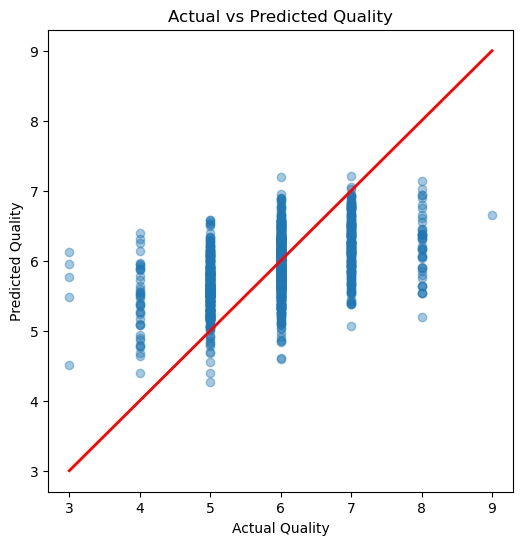

In [17]:
y_pred = model.predict(X_test)

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.4)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         linewidth=2, color='red')
plt.xlabel("Actual Quality")
plt.ylabel("Predicted Quality")
plt.title("Actual vs Predicted Quality")
plt.show()

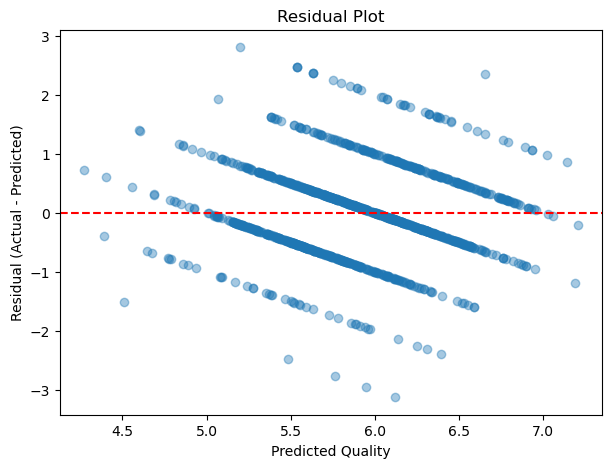

In [18]:
residuals = y_test - y_pred

plt.figure(figsize=(7,5))
plt.scatter(y_pred, residuals, alpha=0.4)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Predicted Quality")
plt.ylabel("Residual (Actual - Predicted)")
plt.title("Residual Plot")
plt.show()

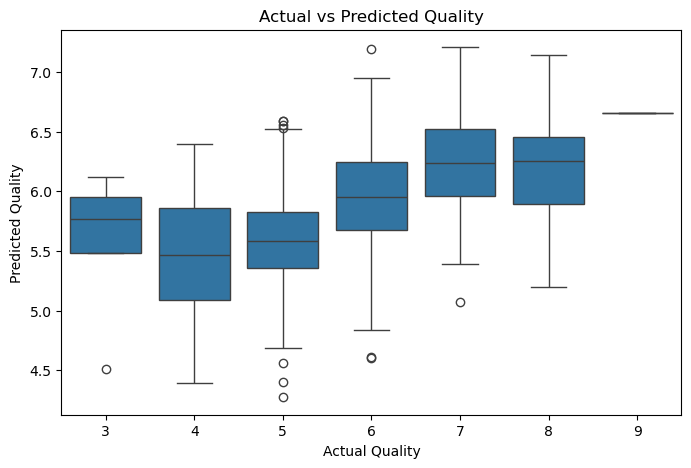

In [19]:
df_viz = pd.DataFrame({
    "Actual Quality": y_test,
    "Predicted Quality": y_pred
})

plt.figure(figsize=(8,5))
sns.boxplot(x="Actual Quality", y="Predicted Quality", data=df_viz)
plt.title("Actual vs Predicted Quality")
plt.show()

## Discussion

When we look at the plot for actual versus predicted quality, we can see that our model had a tendency to predict the middling quality ratings, suggesting the model was biased by the high frequency of quality ratings of 5-7 in our data. While our ridge regression model did tend to predict higher quality values when the actual quality value was higher, the average prediction stayed between ~5 and 6.5 for all actual quality values.

After running our ridge regression analysis, the variables that the model found most informative for predicting the quality rating were the residual sugar and alcohol content, with a higher value of either being correlated on average with a higher predicted quality rating. Intuitively this makes sense, as wines with a higher alcohol content are considered to have more body and a richer taste, but there is also a tradeoff between alcohol content and residual sugar (4). The tradeoff was hinted at in our earlier EDA, as a higher alcohol content was associated with a lower residual sugar content. The alcohol content in wines is derived from a longer fermentation process, but this fermentation also consumes more of the sugar, so it's difficult to attain high levels of both.

These findings indicate that although taste is subjective, tasters have a tendency to prefer white wines that maximize the residual sugar and alcohol content, resulting in a full-bodied wine that is not too dry. Going forward, this could prompt winemakers to experiment with grapes with a higher sugar content and fermentation techniques that try to maximize the alcohol content while minimizing the sugar consumed during the process. This also leads us to questions about how aware sommeliers are of their preferences while judging the quality of wine and how closely the quality rating matches the average wine consumer's preferences. Do sommeliers just tend to enjoy sweeter, full-bodied wines, or is that their personal opinion due to their experience? More research could be done into this topic.


# References
1.    Langstaff SA. Sensory quality control in the wine industry. In: Sensory Analysis for Food and Beverage Quality Control. Woodhead Publishing; 2010. p. 236–61. <https://doi.org/10.1533/9781845699512.3.236>

2.    Polášková P, Herszage J, Ebeler S. Wine flavor: chemistry in a glass. Chemical Soc Rev. 2008 Aug 12;37(11):2478–89. <https://doi.org/10.1039/b714455p>

3.    Cortez P, Cerdeira A, Almeida F, Matos T, Reis J. Modeling wine preferences by data mining from physicochemical properties. Decis Support Syst. 2009 Nov;47(4):547–53. <https://doi.org/10.1016/j.dss.2009.05.016> 

4.    Copestake N. How Much Alcohol is in Wine? A Complete Guide [Internet]. Coravin US. 2025 [cited 2025 Nov 22]. Available from: https://www.coravin.ca/blogs/community/wine-101-how-much-alcohol-is-in-wine
‌